We'll first install the necessary packages

A description of the problem and a discussion of the background. 
Business Problem: To identify the neighborhood for opening a liquor boutique. Here, we have taken the data of Toronto to explore the neighborhoods. One of Asia’s biggest wine and liquor boutique, is looking to expand in Canada and will establish an outpost in Toronto.
There would be a pilot boutique and from this exercise we'll identify the most suitable location for the same.

A description of the data and how it will be used to solve the problem.
We import the data of Canada and get Toronto from there. We further break it down to neighborhoods and the corresponding venues. A liquor boutique looks for a certain kind of 
establishments nearby and here we choose the venue types and then filter down by the 'high-end' restaurant.

In [2]:
!pip install BeautifulSoup4

     |████████████████████████████████| 112kB 5.5MB/s eta 0:00:01


In [3]:
!pip install lxml

     |████████████████████████████████| 5.8MB 5.8MB/s eta 0:00:01     |██████████████████████████████▌ | 5.5MB 5.8MB/s eta 0:00:01


In [4]:
!pip install requests

In [5]:
!pip install geopy

     |████████████████████████████████| 112kB 25.5MB/s eta 0:00:01


In [6]:
import  requests
import json

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [7]:
#get html from wiki page and create soup object
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

In [8]:
#parse through the table to get the data in the form of table rows
data=[]
columns=[]
table=soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section=[]
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    #first row is the header
    if (index==0):
        columns = section
    else:
        data.append(section)
#convert list into Pandas dataframe

canada_df=pd.DataFrame(data=data, columns=columns)
canada_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [9]:
#Remove Boroughs that are 'Not assigned'
canada_df = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df.head(10)

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,Malvern / Rouge
11,M3B,North York,Don Mills
12,M4B,East York,Parkview Hill / Woodbine Gardens
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [10]:
# Combining the neighbourhoods with same Postalcode
canada_df = canada_df.groupby(['Postal code','Borough'], sort=False).agg(', '.join)
canada_df.reset_index(inplace=True)
# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
canada_df['Neighborhood'] = np.where(canada_df['Neighborhood'] == 'Not assigned',canada_df['Borough'], canada_df['Neighborhood'])
canada_df

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,The Kingsway / Montgomery Road / Old Mill North
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,Business reply mail Processing CentrE
101,M8Y,Etobicoke,Old Mill South / King's Mill Park / Sunnylea /...


 Methodology and Exploratory Data Analysis¶
The Data Science Workflow for parts 3 & 4 includes:

Data Analysis and Location Data:

Foursquare location data will be leveraged to explore or compare districts around Paris.

Data manipulation and analysis to derive subsets of the initial data.

Identifying the high traffic areas using data visualisation and statistical analysis.

Visualization:

Analysis and plotting visualizations.

Data visualization using various mapping libraries.

Discussion and Conclusions:

Recommendations and results based on the data analysis.

Discussion of any limitations and how the results can be used, and any conclusions that can be drawn.

In [11]:
canada_df.shape

(103, 3)

In [12]:
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
df_toronto = pd.merge(canada_df, lat_lon, how='left', left_on = 'Postal code', right_on = 'Postal Code')
# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government,43.662301,-79.389494


In [14]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [15]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


In [16]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

In [17]:
#add markers to the map
for lat, lng, borough, neighborhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

In [19]:
#Use the Foursquare API to explore the Arrondissements of Toronto (Neighborhoods)
CLIENT_ID = 'BZ25YHX2PVGQL5RBBKRJTK1ZGTH5HO3F5GJSUPRA4AUUTJQR' # your Foursquare ID
CLIENT_SECRET = '1EYY1TWRPBPKP1G32GZ0EI0KMI2UKT3210EARTCQ5YMMQ0HQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: BZ25YHX2PVGQL5RBBKRJTK1ZGTH5HO3F5GJSUPRA4AUUTJQR
CLIENT_SECRET:1EYY1TWRPBPKP1G32GZ0EI0KMI2UKT3210EARTCQ5YMMQ0HQ


Explore the data

In [20]:
# Explore the first Neighborhood in our dataframe.
# Get the Neighborhood's 
df_toronto.loc[0, 'Neighborhood']

'Parkwoods'

In [21]:
neighborhood_latitude = df_toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_toronto.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


Now, we will get the top 100 venues around Parkwoods in 500m

In [22]:

LIMIT = 100 # limit of number of venues returned by Foursquare API



radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 


'https://api.foursquare.com/v2/venues/explore?&client_id=BZ25YHX2PVGQL5RBBKRJTK1ZGTH5HO3F5GJSUPRA4AUUTJQR&client_secret=1EYY1TWRPBPKP1G32GZ0EI0KMI2UKT3210EARTCQ5YMMQ0HQ&v=20180605&ll=43.7532586,-79.3296565&radius=500&limit=100'

Get the results
Get the category of the venue
Store it in a pandas dataframe

In [23]:
results = requests.get(url).json() #get the details of the 100 venues in json format

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(10)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


Get all the neighborhood within toronto area

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Now create a new dataframe called toronto venues

In [26]:


toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )



Parkwoods
Victoria Village
Regent Park / Harbourfront
Lawrence Manor / Lawrence Heights
Queen's Park / Ontario Provincial Government
Islington Avenue
Malvern / Rouge
Don Mills
Parkview Hill / Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale
Rouge Hill / Port Union / Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate / Bloordale Gardens / Old Burnhamthorpe / Markland Wood
Guildwood / Morningside / West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor / Wilson Heights / Downsview North
Thorncliffe Park
Richmond / Adelaide / King
Dufferin / Dovercourt Village
Scarborough Village
Fairview / Henry Farm / Oriole
Northwood Park / York University
East Toronto
Harbourfront East / Union Station / Toronto Islands
Little Portugal / Trinity
Kennedy Park / Ionview / East Birchmount Park
Bayview Village
Do

In [27]:
print(toronto_venues.shape)
toronto_venues.head()

(2110, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [28]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
Alderwood / Long Branch,8,8,8,8,8,8
Bathurst Manor / Wilson Heights / Downsview North,22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
Bedford Park / Lawrence Manor East,22,22,22,22,22,22
...,...,...,...,...,...,...
Willowdale,39,39,39,39,39,39
Woburn,4,4,4,4,4,4
Woodbine Heights,10,10,10,10,10,10


In [29]:
#Unique categories from each neighborhood
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 262 uniques categories.


Now, we have the Neighborhood, their respective venue and categories. Next, we will group the neighborhoods on the basis of occurance of each category


In [30]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
t_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
t_grouped

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,Alderwood / Long Branch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,Bathurst Manor / Wilson Heights / Downsview North,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.045455,0.000000,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,Bedford Park / Lawrence Manor East,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Willowdale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0
89,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
90,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.100000,0.000000,0.0,0.0,0.0,0.0
91,York Mills / Silver Hills,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [32]:
t_grouped.shape

(93, 262)

Print each neighborhood with the 5 most common venues

In [33]:
num_top_venues = 5

for hood in t_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = t_grouped[t_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1               Skating Rink  0.25
2                     Lounge  0.25
3             Breakfast Spot  0.25
4         Miscellaneous Shop  0.00


----Alderwood / Long Branch----
            venue  freq
0     Pizza Place  0.25
1    Skating Rink  0.12
2  Sandwich Place  0.12
3             Gym  0.12
4             Pub  0.12


----Bathurst Manor / Wilson Heights / Downsview North----
           venue  freq
0           Bank  0.09
1    Coffee Shop  0.09
2          Diner  0.05
3    Gas Station  0.05
4  Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park / Lawrence Manor East----
                venue  freq
0          Restaurant  0.09
1  Italian Restaurant  0.09
2      Sandwich Place  0.09
3         Coffee Shop  0.09
4         P

In [41]:
#translate it into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [42]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.Aappend('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = t_grouped['Neighborhood']

for ind in np.arange(t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Latin American Restaurant,Breakfast Spot,Lounge,Dance Studio,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
1,Alderwood / Long Branch,Pizza Place,Coffee Shop,Gym,Sandwich Place,Skating Rink,Pharmacy,Pub,Colombian Restaurant,Comfort Food Restaurant,Doner Restaurant
2,Bathurst Manor / Wilson Heights / Downsview North,Coffee Shop,Bank,Shopping Mall,Park,Diner,Bridal Shop,Restaurant,Deli / Bodega,Ice Cream Shop,Supermarket
3,Bayview Village,Chinese Restaurant,Café,Japanese Restaurant,Bank,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
4,Bedford Park / Lawrence Manor East,Italian Restaurant,Sandwich Place,Restaurant,Coffee Shop,Thai Restaurant,Indian Restaurant,Liquor Store,Pub,Butcher,Café


Now, since ours is a premium liquor boutique, I have looked for stores in the same category and have generated violin plots for the same

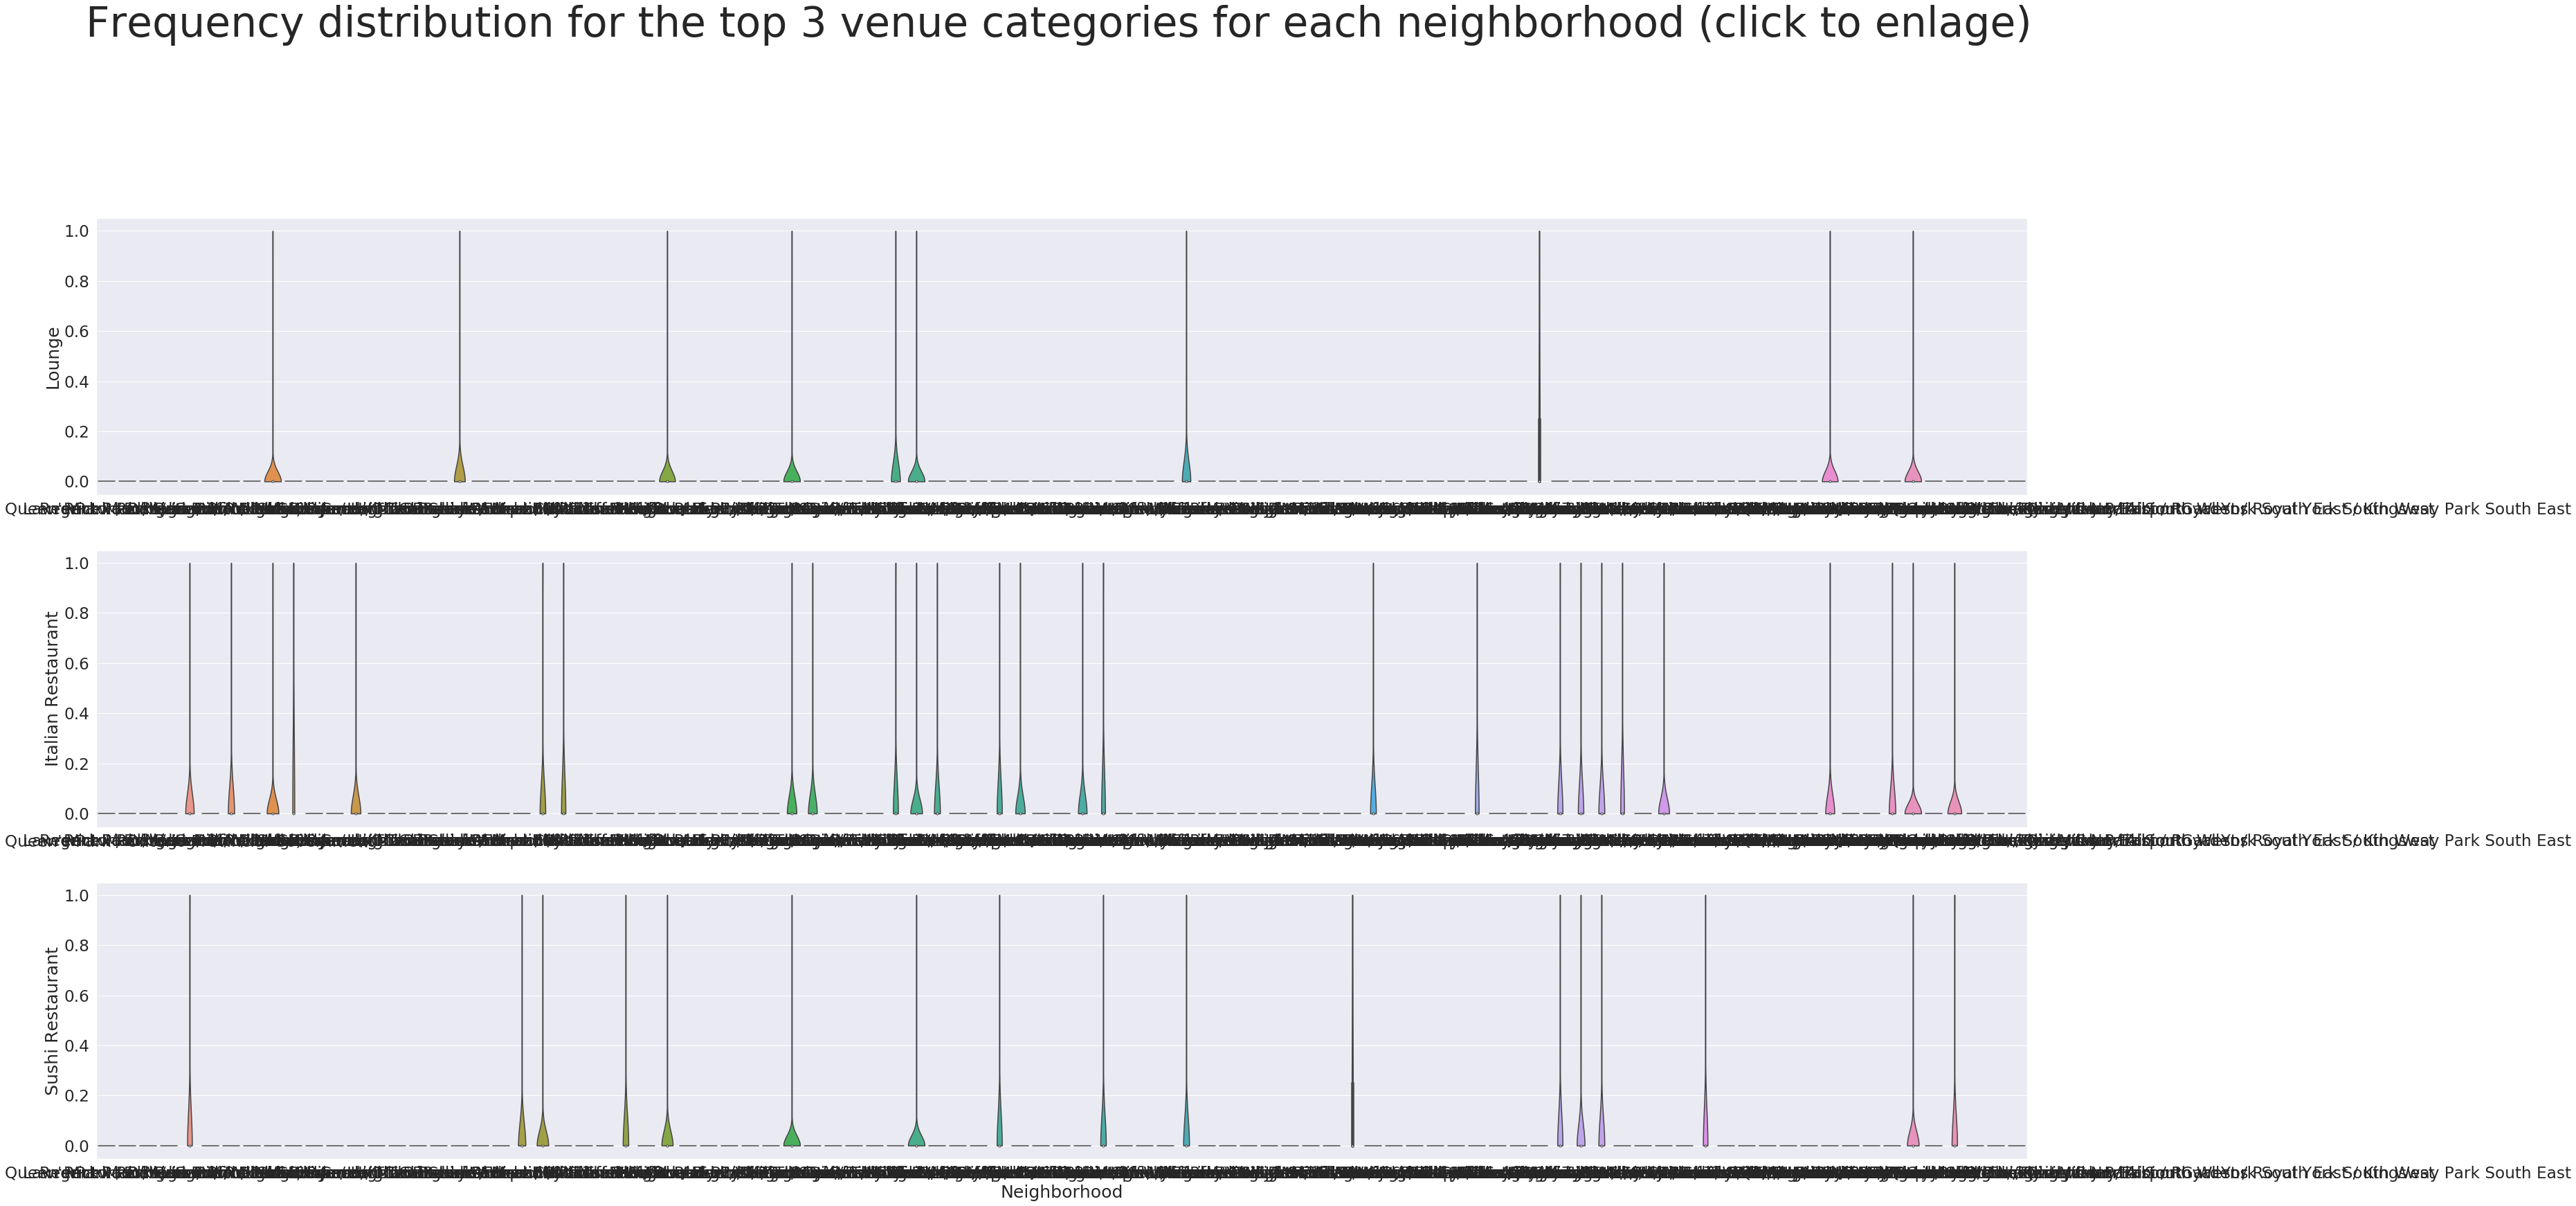

In [43]:
# Categorical plot
# Explore a plot of this data (a violin plot is used which is a density estimation of the underlying distribution).
# The top 3 venue types as specified by the client for each neighborhood are used for the plotting.

import seaborn as sns

fig = plt.figure(figsize=(50,25))
sns.set(font_scale=2.1)

ax = plt.subplot(3,1,1)
sns.violinplot(x="Neighborhood", y="Lounge", data=toronto_onehot, cut=0);
plt.xlabel("")

ax = plt.subplot(3,1,2)
sns.violinplot(x="Neighborhood", y="Italian Restaurant", data=toronto_onehot, cut=0);
plt.xlabel("")

plt.subplot(3,1,3)
sns.violinplot(x="Neighborhood", y="Sushi Restaurant", data=toronto_onehot, cut=0);

ax.text(-1.0, 3.1, 'Frequency distribution for the top 3 venue categories for each neighborhood (click to enlage)', fontsize=60)
plt.savefig ("Distribution_Frequency_Venues_3_categories.png", dpi=240)
plt.show()

In [ ]:
The above violinplot can be used to determine which are the areas suitable for opening the liquor boutique.